In [ ]:
!pip install tensorflow==2.9.1
!pip install tensorflow-text==2.9.0

In [ ]:
!pip install -q -U keras-tuner
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.utils import to_categorical
import mlflow
import mlflow.tensorflow
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import backend as K
import sqlalchemy

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
### setting mlflow with tensorflow
mlflow.tensorflow.autolog(checkpoint=False, checkpoint_save_best_only=False)
mlflow.tensorflow.autolog(disable=True)

### Setting up the tracking store


In [ ]:
## experimental tracking setup
shared_folder = '/content/drive/MyDrive/models_compartida/'
remote_uri = 'sqlite:///' +  shared_folder + 'my_runs.db'
mlflow.set_tracking_uri(remote_uri)
print(mlflow.get_tracking_uri())

sqlite:////content/drive/MyDrive/models_compartida/my_runs.db


### Get embeddings

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
trian_sentences_tokenized = []
for matrix in test[['name', 'description']].values:
  text_out = " ".join(text if not pd.isna(text) else "" for text in matrix)
  test_sentences_tokenized.append(tokenizer(text_out, return_tensors='tf', padding='max_length', max_length=128, truncation=True))

In [ ]:
embedding_bert = []
for i, token in enumerate(test_sentences_tokenized):
  if i % 5000 == 0 : print(i)
  outputs = model(token)
  embedding_bert.append(outputs.last_hidden_state[:,0].numpy().reshape(-1,))

In [ ]:
with open('/content/drive/MyDrive/final_project/bert/dataset/embeddings_joined/test_embeddings.pkl', 'wb') as f:
  pickle.dump(embedding_bert, f)

### Configure data

In [ ]:

## Get embeddings
def load_data():
  """
    This function obtains the data, like data.csv and embeddings from bert.

    Return:
      train: Dataframe.
      test: Daraframe.
      val: Dataframe.
      train_data_join: np.array.
      test_data_join: np.array.
      val_data_join: np.array.
  """
  global train
  global test
  global val
  global train_data_join
  global test_data_join
  global val_data_join

  train = pd.read_csv('/content/drive/MyDrive/final_project/bert/dataset/train.csv')
  test = pd.read_csv('/content/drive/MyDrive/final_project/bert/dataset/test.csv')
  val = pd.read_csv('/content/drive/MyDrive/final_project/bert/dataset/val.csv')

  with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_joined/train_embeddings.pkl", "rb") as f:
    train_data_join = pickle.load(f)
    train_data_join = np.array(train_data_join)

  with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_joined/test_embeddings.pkl", "rb") as f:
    test_data_join = pickle.load(f)
    test_data_join = np.array(test_data_join)

  with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_joined/val_embeddings.pkl", "rb") as f:
    val_data_join = pickle.load(f)
    val_data_join = np.array(val_data_join)



In [ ]:
#train_sentences = train['description']
def get_data():
  """
    This function creates the Datasets to train and validate the model.

    Return:
      dataset_train: tf.data.Dataset.
      dataset_test: tf.data.Dataset.
  """
  global LEVEL
  global NUMBER_OUT
  global COMPUTE_CLASS
  global train_label_le
  global train_label_cate
  global test_label_le
  global test_label_cate
  global val_label_le
  global val_label_cate
  global dataset_train
  global dataset_test
  global train
  global test
  global val
  global train_data_join
  global test_data_join
  global val_data_join
  global class_names

  load_data()

  train_labels = train[f'subcat{LEVEL}_name']
  test_labels = test[f'subcat{LEVEL}_name']
  val_labels = val[f'subcat{LEVEL}_name']

  if 1 == LEVEL:
    train_labels[pd.isna(train_labels)] = 'Other'
    test_labels[pd.isna(test_labels)] = 'Other'
    val_labels[pd.isna(val_labels)] = 'Other'
  else:
    mask_null_train = ~pd.isna(train_labels)
    mask_null_test = ~pd.isna(test_labels)
    mask_null_val = ~pd.isna(val_labels)

    train_labels = train_labels[mask_null_train]
    test_labels = test_labels[mask_null_test]
    val_labels = val_labels[mask_null_val]

    train_data_join = train_data_join[mask_null_train]
    test_data_join = test_data_join[mask_null_test]
    val_data_join = val_data_join[mask_null_val]


  artifacts = '/content/drive/MyDrive/models_compartida/artifacts/Label_encoders'
  listdis = os.listdir(artifacts)

  if f'label_encoder_level{LEVEL}.pkl' in listdis:
    with open(f'{artifacts}/label_encoder_level{LEVEL}.pkl', 'rb') as f:
      le = pickle.load(f)
      train_label_le = le.transform(train_labels)
    print('loaded')
  else:
    le = LabelEncoder()
    train_label_le = le.fit_transform(train_labels)
    with open(f'{artifacts}/label_encoder_level{LEVEL}.pkl', 'wb') as f:
      pickle.dump(le, f)
    print('created and saved')

  class_names = le.classes_
  train_label_cate = to_categorical(train_label_le)
  test_label_le = le.transform(test_labels)
  test_label_cate = to_categorical(test_label_le)
  val_label_le = le.transform(val_labels)
  val_label_cate = to_categorical(val_label_le)
  NUMBER_OUT = len(train_labels.unique())
  print(len(train_label_cate))
  print(len(test_label_cate))
  print(NUMBER_OUT)

  COMPUTE_CLASS = compute_class_weight(class_weight="balanced", classes=np.unique(train_label_le), y=train_label_le)
  COMPUTE_CLASS = {i:value for i, value in enumerate(COMPUTE_CLASS) }
  print(COMPUTE_CLASS)

  dataset_train = tf.data.Dataset.from_tensor_slices((train_data_join, train_label_cate))
  dataset_train = dataset_train.cache().batch(256).shuffle(buffer_size=5000).prefetch(buffer_size=tf.data.AUTOTUNE)
  dataset_test = tf.data.Dataset.from_tensor_slices((val_data_join, val_label_cate))
  dataset_test = dataset_test.cache().batch(256).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



### Create the experiment for the category level

In [ ]:
# create a ml experiment
def create_experiment():
  """
    This function creates the experiment in the experiment tracking database

    Return:
      LEVEL: int level of the category
      MLFLOW_EXPERIMENT_NAME: str name of the experiment
  """

  global LEVEL
  global MLFLOW_EXPERIMENT_NAME
  MLFLOW_EXPERIMENT_NAME = f"text model level {LEVEL}"
  artifact_folder = 'artifacts'
  artifact_location = os.path.join(shared_folder, artifact_folder)

  try:

    mlflow_experiment_id = mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME,
                                                  artifact_location=artifact_location)
  except Exception as e:
    print('problem')
    print(f'error = {e}')

  finally:
    print('set experiment')
    experiment = mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

  print(mlflow.get_artifact_uri())

### search the architecture using keras tuner

In [ ]:
def model_builder(hp):
  tf.keras.backend.clear_session()
  input_layer = Input((768,))

  # units 500 to 1200
  hp_units1_500a1200 = hp.Int('units11', min_value=500 , max_value=1200, step=100)
  hp_units2_500a1200 = hp.Int('units12', min_value=500 , max_value=1200, step=100)
  hp_units3_500a1200 = hp.Int('units13', min_value=500 , max_value=1200, step=100)
  hp_units4_500a1200 = hp.Int('units14', min_value=500 , max_value=1200, step=100)

  # units intermediates
  hp_units1_100a500 = hp.Int('units21', min_value=100, max_value=548, step=64)
  hp_units2_100a500 = hp.Int('units22', min_value=100, max_value=548, step=64)
  hp_units3_100a500 = hp.Int('units23', min_value=100, max_value=548, step=64)
  hp_units4_100a500 = hp.Int('units24', min_value=100, max_value=548, step=64)
  hp_units5_100a500 = hp.Int('units25', min_value=100, max_value=548, step=64)

  # finals units
  hp_units1_16a128 = hp.Int('units31', min_value=16, max_value=128, step=16)
  hp_units2_16a128 = hp.Int('units32', min_value=16, max_value=128, step=16)
  #hp_units3_16a128 = hp.Int('units33', min_value=16, max_value=128, step=16)

  # activations
  hp_activation1 = hp.Choice('activation1', values=['relu', 'leaky_relu'])
  hp_activation2 = hp.Choice('activation2', values=['relu', 'leaky_relu'])
  hp_activation3 = hp.Choice('activation3', values=['relu', 'leaky_relu'])

  #drops
  hp_dropout1 = hp.Float('dropout1', min_value=0.001, max_value=0.5, step=1.1, sampling='log')
  hp_dropout2 = hp.Float('dropout2', min_value=0.001, max_value=0.5, step=1.1, sampling='log')
  hp_dropout3 = hp.Float('dropout3', min_value=0.001, max_value=0.5, step=1.1, sampling='log')

  # Regularizations
  hp_regularizer1 = hp.Choice('regularizer_kerner1', values=[0.01, 0.02, 0.1, 0.12, 0.2])
  hp_regularizer2 = hp.Choice('regularizer_kerner2', values=[0.01, 0.02, 0.1, 0.12, 0.2])
  hp_regularizer3 = hp.Choice('regularizer_kerner3', values=[0.01, 0.02, 0.1, 0.12, 0.2])


  hp_learning = hp.Choice('learning', values=[1e-3, 1e-4, 1e-5])

  ## initial

  x = Dense(hp_units1_500a1200, activation=hp_activation1, name='input_dense_layer')(input_layer)
  x = Dropout(hp_dropout1)(x)

  if hp.Boolean('layers_1'):
    x = Dense(hp_units2_500a1200, activation=hp_activation1, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer1),
              name='Dense_boolean1')(x)
    x = Dropout(hp_dropout1)(x)

  if hp.Boolean('layers_2'):
    x = Dense(hp_units3_500a1200, activation=hp_activation1, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer1),
              name='Dense_boolean2')(x)
    x = Dropout(hp_dropout1)(x)

  if hp.Boolean('layers_3'):
    x = Dense(hp_units4_500a1200, activation=hp_activation1, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer1),
              name='Dense_boolean3')(x)
    x = Dropout(hp_dropout1)(x)

  ## inter

  x = Dense(hp_units1_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
            name='intermediate_layer1')(x)
 # x = Dense(hp_units2_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
 #           name='intermediate_layer2')(x)
  x = Dropout(hp_dropout2)(x)


  if hp.Boolean('layers_4'):
    x = Dense(hp_units3_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
              name='Dense_boolean4')(x)
    x = Dropout(hp_dropout2)(x)

  if hp.Boolean('layers_5'):
    x = Dense(hp_units4_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
              name='Dense_boolean5')(x)
    x = Dropout(hp_dropout2)(x)



  ## finals

  x = Dense(hp_units1_16a128, activation=hp_activation3, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer3),
            name='final_layer1')(x)

  if hp.Boolean('layers_7'):
    x = Dense(hp_units2_16a128, activation=hp_activation3, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer3),
            name='final_layer2')(x)
    x = Dropout(hp_dropout3)(x)

  output_layer = Dense(number_out)(x)

  model = tf.keras.Model(input_layer, output_layer)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

  return model

def double_input_model_builder(hp):

  tf.keras.backend.clear_session()
  #input_layer = Input((768,))

  # units 500 to 1200
  hp_unitsx11_500a1200 = hp.Int('unitsx11', min_value=500 , max_value=1200, step=100)
  hp_unitsx12_500a1200 = hp.Int('unitsx12', min_value=500 , max_value=1200, step=100)
  hp_unitsx21_500a1200 = hp.Int('unitsx21', min_value=500 , max_value=1200, step=100)
  hp_unitsx22_500a1200 = hp.Int('unitsx22', min_value=500 , max_value=1200, step=100)

  hp_units1_500a1200 = hp.Int('units11', min_value=500 , max_value=1200, step=100)
  hp_units2_500a1200 = hp.Int('units12', min_value=500 , max_value=1200, step=100)
  hp_units3_500a1200 = hp.Int('units13', min_value=500 , max_value=1200, step=100)
  hp_units4_500a1200 = hp.Int('units14', min_value=500 , max_value=1200, step=100)

  # units intermediates
  hp_units1_100a500 = hp.Int('units21', min_value=100, max_value=548, step=64)
  #hp_units2_100a500 = hp.Int('units22', min_value=100, max_value=548, step=64)
  hp_units3_100a500 = hp.Int('units23', min_value=100, max_value=548, step=64)
  hp_units4_100a500 = hp.Int('units24', min_value=100, max_value=548, step=64)
  hp_units5_100a500 = hp.Int('units25', min_value=100, max_value=548, step=64)

  # finals units
  hp_units1_16a128 = hp.Int('units31', min_value=16, max_value=128, step=16)
  hp_units2_16a128 = hp.Int('units32', min_value=16, max_value=128, step=16)
  hp_units3_16a128 = hp.Int('units33', min_value=16, max_value=128, step=16)

  # activations
  hp_activation1 = hp.Choice('activation1', values=['relu', 'leaky_relu'])
  hp_activation2 = hp.Choice('activation2', values=['relu', 'leaky_relu'])
  hp_activation3 = hp.Choice('activation3', values=['relu', 'leaky_relu'])

  hp_activationx1 = hp.Choice('activationx1', values=['relu', 'leaky_relu'])

  #drops
  hp_dropoutx1 = hp.Float('dropoutx1', min_value=0.001, max_value=0.5, step=1.1, sampling='log')

  hp_dropout1 = hp.Float('dropoutx1', min_value=0.001, max_value=0.5, step=1.1, sampling='log')
  hp_dropout2 = hp.Float('dropout2', min_value=0.001, max_value=0.5, step=1.1, sampling='log')
  hp_dropout3 = hp.Float('dropout3', min_value=0.001, max_value=0.5, step=1.1, sampling='log')

  # Regularizations
  hp_regularizer1 = hp.Choice('regularizer_kerner1', values=[0.01, 0.02, 0.1, 0.12, 0.2])
  hp_regularizer2 = hp.Choice('regularizer_kerner2', values=[0.01, 0.02, 0.1, 0.12, 0.2])
  hp_regularizer3 = hp.Choice('regularizer_kerner3', values=[0.01, 0.02, 0.1, 0.12, 0.2])

  hp_regularizerx1 = hp.Choice('regularizer_kernerx1', values=[0.01, 0.02, 0.1, 0.12, 0.2])
  hp_regularizerx2 = hp.Choice('regularizer_kernerx2', values=[0.01, 0.02, 0.1, 0.12, 0.2])

  hp_learning = hp.Choice('learning', values=[1e-4, 1e-5])

  # inputs
  input_layer_descrip = Input((768,))
  input_layer_name = Input((768,))

  # layer for descrip

  x1 = Dense(hp_unitsx11_500a1200, activation=hp_activationx1,
             kernel_regularizer=tf.keras.regularizers.l2(hp_regularizerx1),
             name='input_layer_descrip')(input_layer_descrip)
  if hp.Boolean('layers_input_x1'):
    x1 = Dense(hp_unitsx12_500a1200, activation=hp_activationx1,
               kernel_regularizer=tf.keras.regularizers.l2(hp_regularizerx1),
               name= 'boolean_input_layer_descrip')(x1)
    x1 = Dropout(hp_dropoutx1)(x1)

  # layer for name

  x2 = Dense(hp_unitsx21_500a1200, activation=hp_activationx1,
             kernel_regularizer=tf.keras.regularizers.l2(hp_regularizerx2),
             name='input_layer_name')(input_layer_name)
  if hp.Boolean('layers_input_x2'):
    x2 = Dense(hp_unitsx22_500a1200, activation=hp_activationx1,
               kernel_regularizer=tf.keras.regularizers.l2(hp_regularizerx2),
               name= 'boolean_input_layer_name')(x2)
    x2 = Dropout(hp_dropoutx1)(x2)

  x = concatenate([x1, x2])

  ## model

  x = Dense(hp_units1_500a1200, activation=hp_activation1, name='input_dense_layer')(x)
  x = Dropout(hp_dropout1)(x)

  if hp.Boolean('layers_1'):
    x = Dense(hp_units2_500a1200, activation=hp_activation1, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer1),
              name='Dense_boolean1')(x)
    x = Dropout(hp_dropout1)(x)

  if hp.Boolean('layers_2'):
    x = Dense(hp_units3_500a1200, activation=hp_activation1, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer1),
              name='Dense_boolean2')(x)
    x = Dropout(hp_dropout1)(x)

  ## inter

  x = Dense(hp_units1_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
            name='intermediate_layer1')(x)
  x = Dropout(hp_dropout2)(x)


  if hp.Boolean('layers_3'):
    x = Dense(hp_units3_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
              name='Dense_boolean3')(x)
    x = Dropout(hp_dropout2)(x)

  if hp.Boolean('layers_4'):
    x = Dense(hp_units4_100a500, activation=hp_activation2, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer2),
              name='Dense_boolean4')(x)
    x = Dropout(hp_dropout2)(x)


  ## finals

  x = Dense(hp_units1_16a128, activation=hp_activation3, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer3),
            name='final_layer1')(x)

  if hp.Boolean('layers_5'):
    x = Dense(hp_units2_16a128, activation=hp_activation3, kernel_regularizer=tf.keras.regularizers.l2(hp_regularizer3),
            name='final_layer2')(x)
    x = Dropout(hp_dropout3)(x)

  output_layer = Dense(number_out)(x)

  model = tf.keras.Model(inputs=[input_layer_descrip, input_layer_name], outputs=output_layer)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', F1Score(number_out, average='weighted')]
              )

  return model


In [ ]:
tuner = kt.Hyperband(double_input_model_builder,
                     objective=kt.Objective('val_f1_score', direction='max'),
                     max_epochs=50,
                     factor=5,
                     directory='/content/drive/MyDrive/final_project/bert/multiple_inputs/small_model_joined_data',
                     project_name='kt_first_run',
                     hyperband_iterations=2,

                     )

call_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=2)


In [ ]:
NUM_EPOCHS = 100
tuner.search(dataset_train, epochs=NUM_EPOCHS, validation_data=dataset_test, callbacks=[call_early])


Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
900               |700               |unitsx11
800               |1200              |unitsx12
900               |1000              |unitsx21
1100              |1200              |unitsx22
1000              |600               |units11
600               |700               |units12
700               |1200              |units13
1100              |800               |units14
292               |100               |units21
420               |292               |units23
100               |420               |units24
292               |548               |units25
80                |64                |units31
64                |16                |units32
64                |96                |units33
leaky_relu        |relu              |activation1
leaky_relu        |leaky_relu        |activation2
relu              |leaky_relu        |activation3
leaky_relu        |relu              |activationx1
0.0014641         |0.006

KeyboardInterrupt: 

In [ ]:
number_out = 13
bts_model = tuner.get_best_models(num_models=1)[0]
bts_model.summary()

IndexError: list index out of range

In [ ]:
conf = bts_model.get_config()

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/final_project/bert/dataset/train.csv')
#train.head()
test = pd.read_csv('/content/drive/MyDrive/final_project/bert/dataset/test.csv')

train_labels = train['subcat1_name']
test_labels = test['subcat1_name']

In [ ]:
with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_descript/embedings_bert_descrip_full.pkl", "rb") as f:
  train_data_descrip = pickle.load(f)
  train_data_descrip = np.array(train_data_descrip)

with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_descript/embeddings_bert_destrip_test_full.pkl", "rb") as f:
  test_data_descrip = pickle.load(f)
  test_data_descrip = np.array(test_data_descrip)

with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_name/embedings_bert_name_train.pkl", 'rb') as f:
  train_data_name = pickle.load(f)
  train_data_name = np.array(train_data_name)

with open("/content/drive/MyDrive/final_project/bert/dataset/embeddings_name/embeddings_bert_name_test.pkl", 'rb') as f:
  test_data_name =pickle.load(f)
  test_data_name = np.array(test_data_name)

In [ ]:
import os
listdis = os.listdir('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts')
print('label_encoder.pkl' in listdis)
if 'label_encoder.pkl' in listdis:
  with open('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)
    train_label_le = le.transform(train_labels)
  print('carge')
else:
  le = LabelEncoder()
  train_label_le = le.fit_transform(train_labels)


train_label_cate = to_categorical(train_label_le)
test_label_le = le.transform(test_labels)
test_label_cate = to_categorical(test_label_le)
len(train_label_cate)
len(test_label_cate)

compute_class = compute_class_weight(class_weight="balanced", classes=np.unique(train_label_le), y=train_label_le)
class_weight = {i:value for i, value in enumerate(compute_class) }
print(class_weight)

False
{0: 0.4258687713511603, 1: 1.085873907427988, 2: 1.0837580190658913, 3: 1.4879203193809936, 4: 0.5756412910211296, 5: 0.6537195761455282, 6: 0.8041998487342616, 7: 3.163735013564365, 8: 1.3148572467721404, 9: 2.7344376370925043, 10: 1.8164095864944982, 11: 5.854574898785425, 12: 0.6839456657459608}


In [ ]:
call_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)


In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices(((train_data_descrip, train_data_name), train_label_cate))
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE).batch(512)
dataset_test =  tf.data.Dataset.from_tensor_slices(((test_data_descrip, test_data_name), test_label_cate))
dataset_test = dataset_test.batch(512).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
tf.keras.backend.clear_session()
n_model = tf.keras.Model.from_config(conf)

In [ ]:
n_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', F1Score(number_out, average='weighted')]
              )

In [ ]:

history = n_model.fit(dataset_train, epochs=100, validation_data=dataset_test, callbacks=[call_early])

Epoch 1/100
71/71 [==============================] - 44s 476ms/step - loss: 71.6271 - accuracy: 0.4530 - f1_score: 0.3837 - val_loss: 59.1910 - val_accuracy: 0.6459 - val_f1_score: 0.6091
Epoch 2/100
71/71 [==============================] - 29s 410ms/step - loss: 50.2328 - accuracy: 0.6776 - f1_score: 0.6507 - val_loss: 41.9319 - val_accuracy: 0.7331 - val_f1_score: 0.7090
Epoch 3/100
71/71 [==============================] - 28s 395ms/step - loss: 35.7597 - accuracy: 0.7382 - f1_score: 0.7179 - val_loss: 29.9515 - val_accuracy: 0.7666 - val_f1_score: 0.7461
Epoch 4/100
71/71 [==============================] - 28s 387ms/step - loss: 25.6419 - accuracy: 0.7614 - f1_score: 0.7428 - val_loss: 21.5496 - val_accuracy: 0.7812 - val_f1_score: 0.7614
Epoch 5/100
71/71 [==============================] - 29s 412ms/step - loss: 18.5415 - accuracy: 0.7753 - f1_score: 0.7576 - val_loss: 15.6600 - val_accuracy: 0.7914 - val_f1_score: 0.7727
Epoch 6/100
71/71 [==============================] - 29s 414

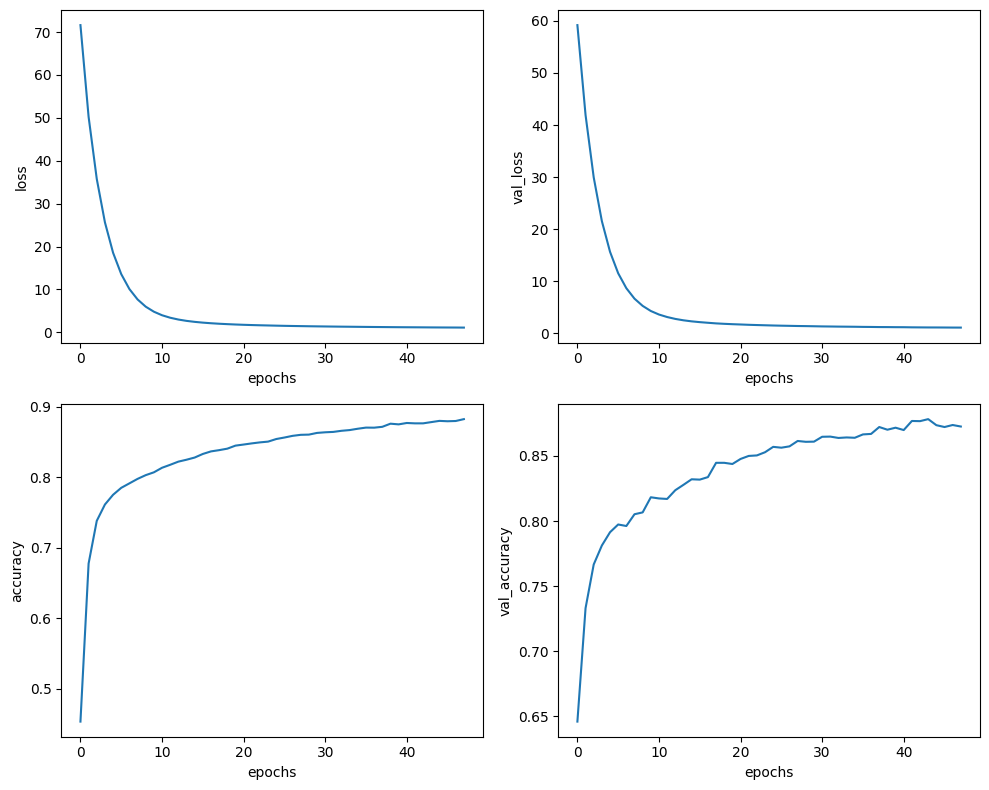

In [ ]:
plots_gra(history)

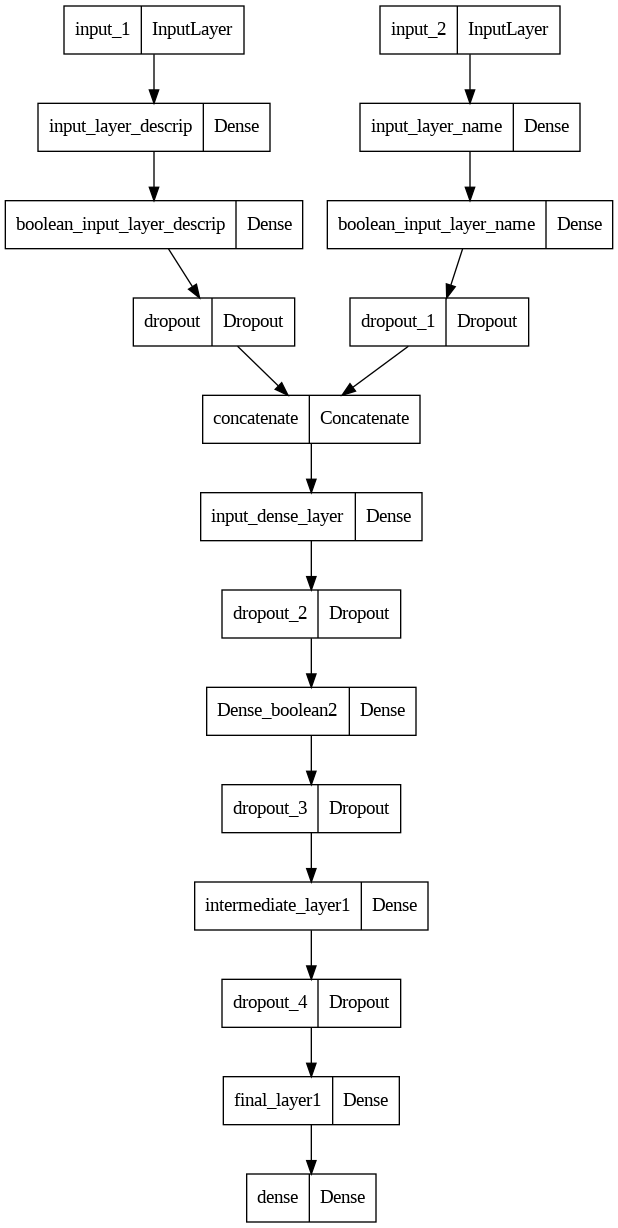

In [ ]:
tf.keras.utils.plot_model(n_model)

In [ ]:
with open('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/best_model2.pkl', "wb") as f:
  pickle.dump(bts_model, f)


In [ ]:
with open('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/best_model.pkl', "rb") as f:
  model = pickle.load(f)

ModuleNotFoundError: No module named 'keras.src'

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/model.keras')

OSError: Unable to synchronously open file (file signature not found)

In [ ]:
best_hyper = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyper.values

{'unitsx11': 700,
 'unitsx12': 1200,
 'unitsx21': 1000,
 'unitsx22': 1200,
 'units11': 600,
 'units12': 700,
 'units13': 1200,
 'units14': 800,
 'units21': 100,
 'units23': 292,
 'units24': 420,
 'units25': 548,
 'units31': 64,
 'units32': 16,
 'units33': 96,
 'activation1': 'relu',
 'activation2': 'leaky_relu',
 'activation3': 'leaky_relu',
 'activationx1': 'relu',
 'dropoutx1': 0.006115909044841464,
 'dropout2': 0.12912993816766538,
 'dropout3': 0.014420993610649958,
 'regularizer_kerner1': 0.01,
 'regularizer_kerner2': 0.1,
 'regularizer_kerner3': 0.01,
 'regularizer_kernerx1': 0.01,
 'regularizer_kernerx2': 0.02,
 'learning': 1e-05,
 'layers_input_x1': True,
 'layers_input_x2': True,
 'layers_1': False,
 'layers_2': True,
 'layers_3': False,
 'layers_4': False,
 'layers_5': False,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0034'}

In [ ]:
with open('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/best_hyper2.pkl', 'wb') as f:
  pickle.dump(best_hyper, f)

In [ ]:
bts_model.save('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/model2.keras')

In [ ]:
bts_model.save_weights('/content/drive/MyDrive/final_project/bert/multiple_inputs/artifacts/models_keras_tuner/first_run/model2_we',save_format='tf')

In [ ]:
weights = bts_model.get_weights()
#print(weights)

In [ ]:
print(len(weights[1]))

700


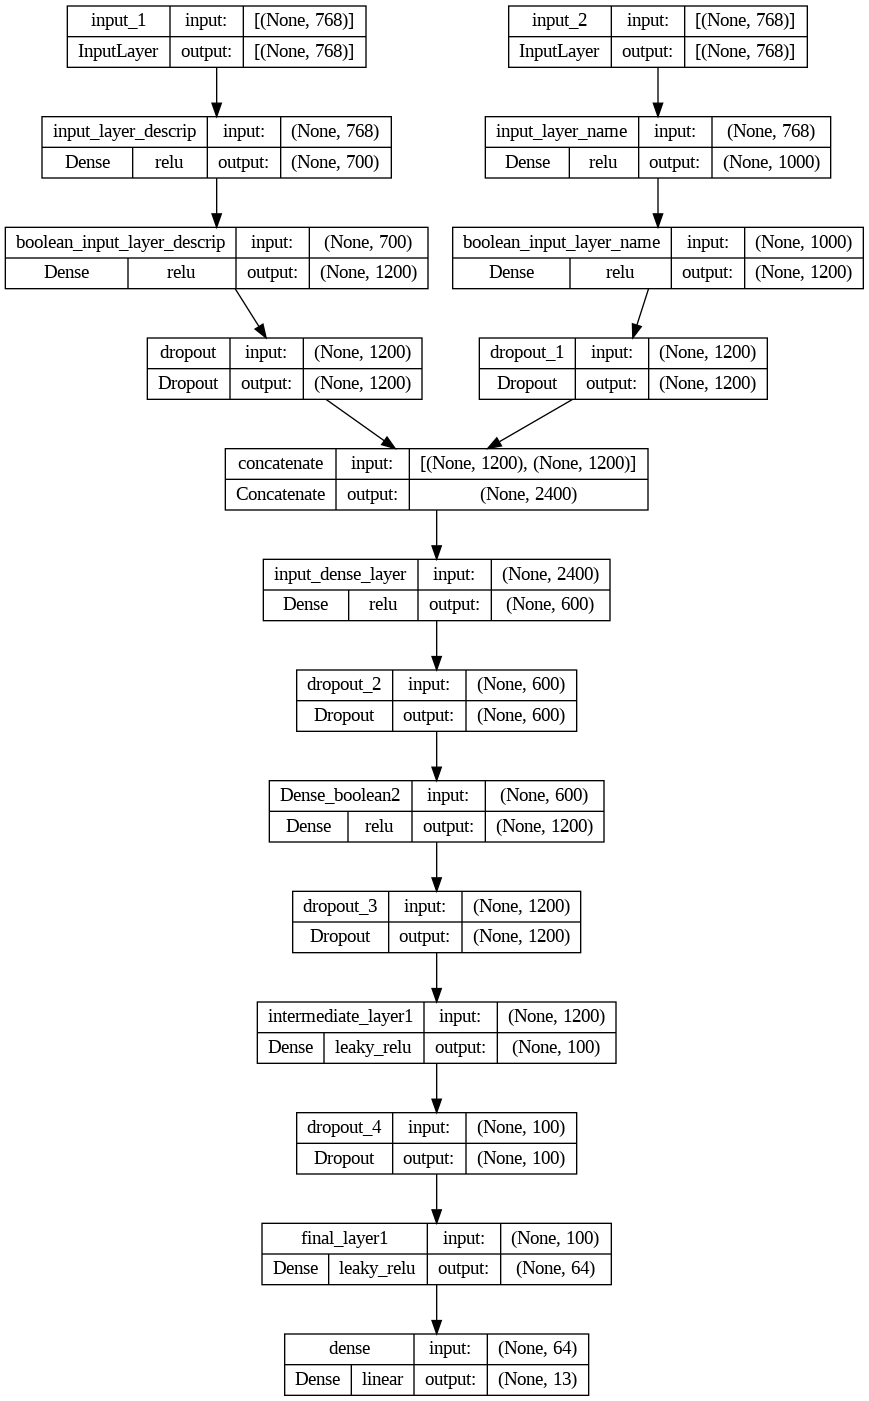

In [ ]:
tf.keras.utils.plot_model(bts_model, 'best_model.png', show_shapes=True, show_layer_activations=True, show_layer_names=True)

### tracking experiment

In [ ]:
class F1Score(tf.keras.metrics.Metric):
  """
    This function is a customized matric to evaluate the F1 score in the training
  """
  def __init__(self, num_classes, average='macro', name='f1_score', **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.average = average
    self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
    self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
    self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.argmax(y_true, axis=-1)

    for i in range(self.num_classes):
      y_pred_i = tf.cast(y_pred == i, tf.float32)
      y_true_i = tf.cast(y_true == i, tf.float32)

      tp = tf.reduce_sum(y_true_i * y_pred_i)
      fp = tf.reduce_sum(y_pred_i) - tp
      fn = tf.reduce_sum(y_true_i) - tp

      self.true_positives[i].assign(self.true_positives[i] + tp)
      self.false_positives[i].assign(self.false_positives[i] + fp)
      self.false_negatives[i].assign(self.false_negatives[i] + fn)

  def result(self):
    precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
    recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    if self.average == 'macro':
      return tf.reduce_mean(f1)
    elif self.average == 'weighted':
      weights = self.true_positives + self.false_negatives
      return tf.reduce_sum(f1 * weights) / tf.reduce_sum(weights)
    else:
      raise ValueError(f'Unknown average type: {self.average}')

  def reset_state(self):
    for i in range(self.num_classes):
      self.true_positives[i].assign(0)
      self.false_positives[i].assign(0)
      self.false_negatives[i].assign(0)

In [ ]:
def get_model_plot(model):
  """
    This function creates the model architecture graph.
  """
  tf.keras.utils.plot_model(model, '/content/plot_model.png',
                                        show_shapes=True,
                                        show_dtype=True,
                                        show_layer_names=True,
                                        show_layer_activations=True,
                                        rankdir='PR'
                                        )

In [ ]:
def get_consufion_matrix(set_to_evaluate, true_labels, name):

  """
      this function is to create the confusion matrix with my results
      inputs:
        set_to_evaluate = set of embeddings to evaluate
        true_labels = the labels of set_to_evaluate
        root = Path in where it confussion matrix will be save
  """
  global class_names

  predict = model.predict(set_to_evaluate)
  predict = np.argmax(predict, axis=1)

  cm = confusion_matrix(true_labels, predict)
  fig, ax = plt.subplots(figsize=(10, 8))

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

  fig.tight_layout()
  if name:
    fig.savefig(f'/content/con_matrix_{name}.png')

In [ ]:
def plots_gra(history, save=None):
  """
    This function creates the losses and accuracy plots
  """
  metrics = ['loss', 'accuracy']

  fig, axis = plt.subplots(2,2, figsize=(10, 8))

  axis[0, 0].plot(history.history['loss'])
  axis[0, 0].set_xlabel('epochs')
  axis[0, 0].set_ylabel('loss')

  axis[0, 1].plot(history.history[f'val_loss'])
  axis[0, 1].set_xlabel('epochs')
  axis[0, 1].set_ylabel(f'val_loss')

  axis[1, 0].plot(history.history['accuracy'])
  axis[1, 0].set_xlabel('epochs')
  axis[1, 0].set_ylabel('accuracy')

  axis[1, 1].plot(history.history[f'val_accuracy'])
  axis[1, 1].set_xlabel('epochs')
  axis[1, 1].set_ylabel(f'val_accuracy')

  fig.tight_layout()

  if save:
    plt.savefig('/content/metrics.png')
    #fig.savefig(save_root + '/metrics.png')
    #plt.close()
  plt.show()

In [ ]:
def clear_enviroment():
  """
    This funtion to clear my dirrectory
  """
  tf.keras.backend.clear_session()
  if 'model' in dir() :
    print("i am cutting")
    del(model)

In [ ]:
# Callback to evaluate the model
call_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=9, restore_best_weights=True)
class CustomCallback(tf.keras.callbacks.Callback):
  """
    Customizer class to log the metrics model in mlflow
  """
  def on_epoch_end(self, epoch, logs=None):
    """
      This function log the metrics on epoch end
    """
    mlflow.log_metric('loss', logs.get('loss'), step=epoch)
    mlflow.log_metric('accuracy', logs.get('accuracy'), step=epoch)
    mlflow.log_metric('val_loss', logs.get('loss'), step=epoch)
    mlflow.log_metric('val_accuracy', logs.get('val_accuracy'), step=epoch)
    mlflow.log_metric('f1_score', logs.get('f1_score'), step=epoch)
    mlflow.log_metric('val_f1_score', logs.get('val_f1_score'), step=epoch)

In [ ]:
##model
def give_me_my_model(learning_rate, epoch_to_decay, decay, number_of_output_neurons, d1, d2, d3, d4):
  tf.keras.backend.clear_session()
# inputs
  input_layer = Input((768,))

  #x = Dense(512, activation='relu',name='input_layer', kernel_regularizer=tf.keras.regularizers.l2(0.2))(input_layer)
  #x = Dropout(0.2)(input_layer)

  #x = Dense(512, activation='relu',name='input_layer', kernel_regularizer=tf.keras.regularizers.l2(0.2))(input_layer)
  #x = Dropout(0.2)(input_layer)

  #x = Dense(512, activation='relu',name='dense_B1',kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
  #x = Dropout(0.01)(x)

  #x = Dense(512, activation='relu',name='dense_B2',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  #x = Dropout(0.01)(x)

  #x = Dense(256, activation='leaky_relu',name='denseM1',kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  #x = Dropout(0.01)(x)

  x = Dense(d1, activation='relu',name='denseM1')(input_layer)
  x = Dropout(0.02)(x)
  #x = Dense(128, activation='relu',name='denseM2',)(x)

  #x = Dropout(0.01)(x)

  x = Dense(d2, activation='leaky_relu',name='denseE1',)(x)
  x = Dropout(0.01)(x)

  #x = Dense(d2, activation='leaky_relu',name='denseE2',)(x)

  if d3 != 0:
    x = Dense(d3, activation='leaky_relu',name='denseE3',)(x)
    x = Dropout(0.01)(x)

  if d4 != 0:
    x = Dense(d4, activation='leaky_relu',name='denseE4',)(x)
    x = Dropout(0.01)(x)
  #x = Dense(64, activation='leaky_relu',name='denseE2',)(x)
  #x = Dropout(0.01)(x)

  """
  # layer for descrip

  x = Dense(704, activation='relu',name='input_layer', kernel_regularizer=tf.keras.regularizers.l2(0.2))(input_layer)

  x = Dropout(0.1)(x)

  ## model
  x = Dense(1200, activation='relu', name='dense2', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)
  """
  """
  x= Dense(1456, activation='leaky_relu', name='dense3',  kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)

  x= Dense(1456, activation='leaky_relu', name='dense4',  kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)

  x= Dense(1200, activation='leaky_relu', name='dense5',  kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)

  x = Dense(896, activation='leaky_relu', name='dense6', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
  x = Dropout(0.2 )(x)
  """
  """
  x = Dense(896, activation='leaky_relu', name='dense7', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)

  x = Dense(512, activation='leaky_relu',name='intermediate_layer1', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)

  #x = Dropout(0.1)(x)

  x = Dense(512, activation='leaky_relu', name='intermediate_layer2',  kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2 )(x)


  ## inter
  x = Dense(112, activation='leaky_relu',name='intermediate_layer3', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.2)(x)

  #x = Dense(112, activation='leaky_relu',name='intermediate_layer4')(x)

  ## finals

  x = Dense(96, activation='leaky_relu',name='final_layer1', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
  x = Dropout(0.1)(x)
  """

  output_layer = Dense(number_of_output_neurons)(x)

  model = tf.keras.Model(inputs=[input_layer], outputs=output_layer)


  learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps = epoch_to_decay,
    decay_rate = decay
  )

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', F1Score(number_of_output_neurons, average='weighted',), ]
              )
  return model

In [ ]:
# parmas to train the model
EXPERIMENT_NUMBER = 60
best_f1_so_far = {'val':0, 'test':0}
best_dense = {}
last_dense = []

In [ ]:
## set up the environment for my experiment
LEVEL = 5
create_experiment()
get_data()

problem
error = (sqlite3.IntegrityError) UNIQUE constraint failed: experiments.name
[SQL: INSERT INTO experiments (name, artifact_location, lifecycle_stage, creation_time, last_update_time) VALUES (?, ?, ?, ?, ?)]
[parameters: ('text model level 5', '/content/drive/MyDrive/models_compartida/artifacts', 'active', 1723493127717, 1723493127717)]
(Background on this error at: https://sqlalche.me/e/20/gkpj)
set experiment
/content/drive/MyDrive/models_compartida/artifacts/dc4aea4b516840cea525f4a127822c7b/artifacts
loaded
3924
882
31
{0: 1.582258064516129, 1: 1.8892633606162734, 2: 2.8129032258064517, 3: 2.943735933983496, 4: 2.3440860215053765, 5: 0.252152679604164, 6: 1.0727173318753418, 7: 2.43424317617866, 8: 3.013824884792627, 9: 1.5627240143369177, 10: 2.07509254362771, 11: 2.87683284457478, 12: 1.6022866476112698, 13: 1.7105492589363558, 14: 1.947394540942928, 15: 2.6370967741935485, 16: 3.4210985178727116, 17: 2.0092165898617513, 18: 1.4064516129032258, 19: 0.09179162085662823, 20: 2

best_f1_so_far={'val': 0.8782725306947736, 'test': 0.8473187866422602}
Epoch 1/1000
16/16 [==============================] - 12s 309ms/step - loss: 3.3128 - accuracy: 0.0793 - f1_score: 0.0640 - val_loss: 3.2918 - val_accuracy: 0.2155 - val_f1_score: 0.1729
Epoch 2/1000
16/16 [==============================] - 2s 115ms/step - loss: 2.9526 - accuracy: 0.1904 - f1_score: 0.1484 - val_loss: 3.0263 - val_accuracy: 0.2798 - val_f1_score: 0.2371
Epoch 3/1000
16/16 [==============================] - 2s 129ms/step - loss: 2.5213 - accuracy: 0.3310 - f1_score: 0.2675 - val_loss: 2.7411 - val_accuracy: 0.3667 - val_f1_score: 0.2983
Epoch 4/1000
16/16 [==============================] - 1s 91ms/step - loss: 2.0868 - accuracy: 0.3914 - f1_score: 0.3201 - val_loss: 2.4440 - val_accuracy: 0.4369 - val_f1_score: 0.3638
Epoch 5/1000
16/16 [==============================] - 1s 58ms/step - loss: 1.6799 - accuracy: 0.4434 - f1_score: 0.3635 - val_loss: 2.2322 - val_accuracy: 0.4750 - val_f1_score: 0.3918


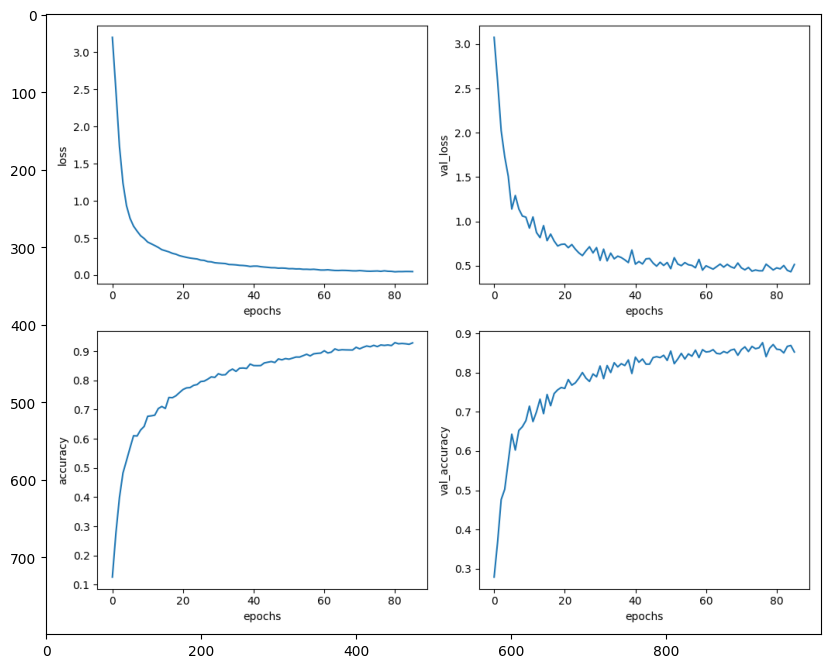

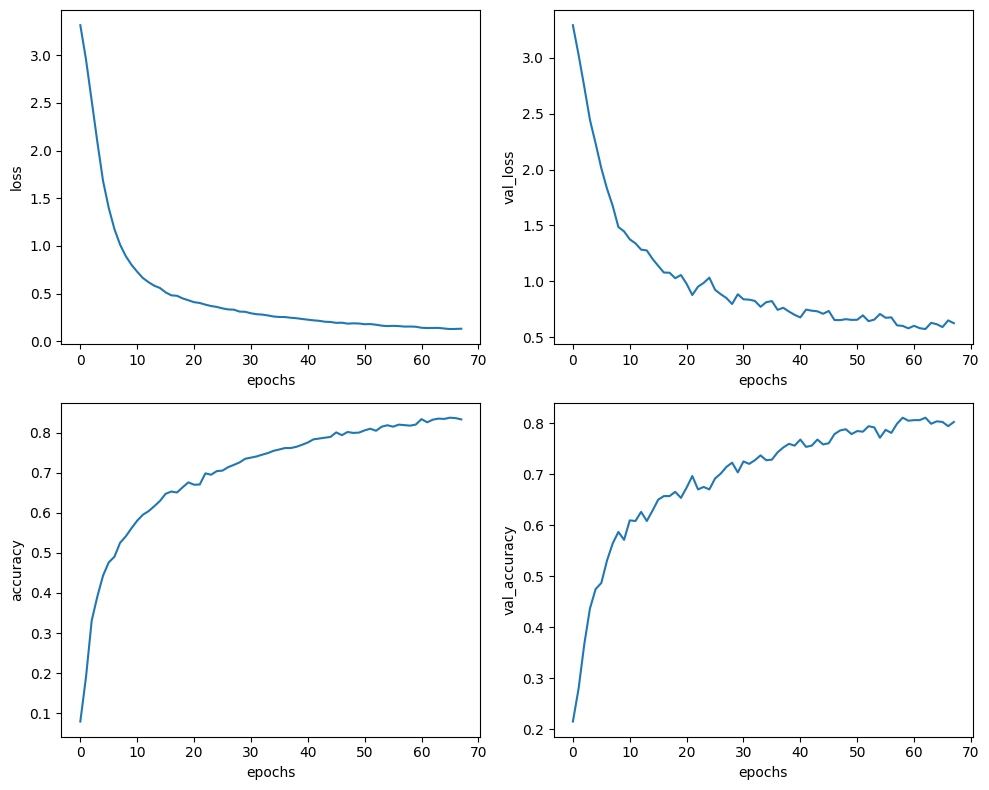

28/28 [==============================] - 0s 9ms/step
f1_test=0.7597393828605717
27/27 [==============================] - 0s 7ms/step
val = f1_val=0.8123522251570662
The best hyperparam so far as lr 0.0002, epochs_to  1960, decay 0.9
{'BEST_DENSE1': 700, 'BEST_DENSE2': 512, 'BEST_DENSE3': 64, 'BEST_DENSE4': 0}
[512, 128, 0, 0, 512, 128, 0, 0, 700, 512, 64, 0, 700, 512, 64, 0]


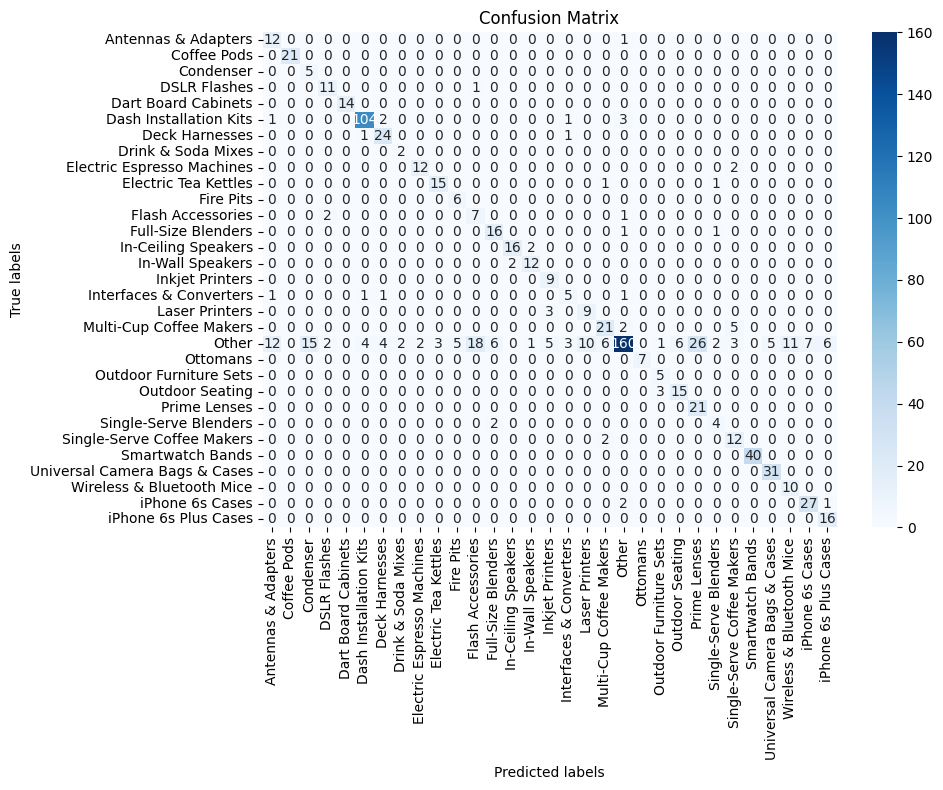

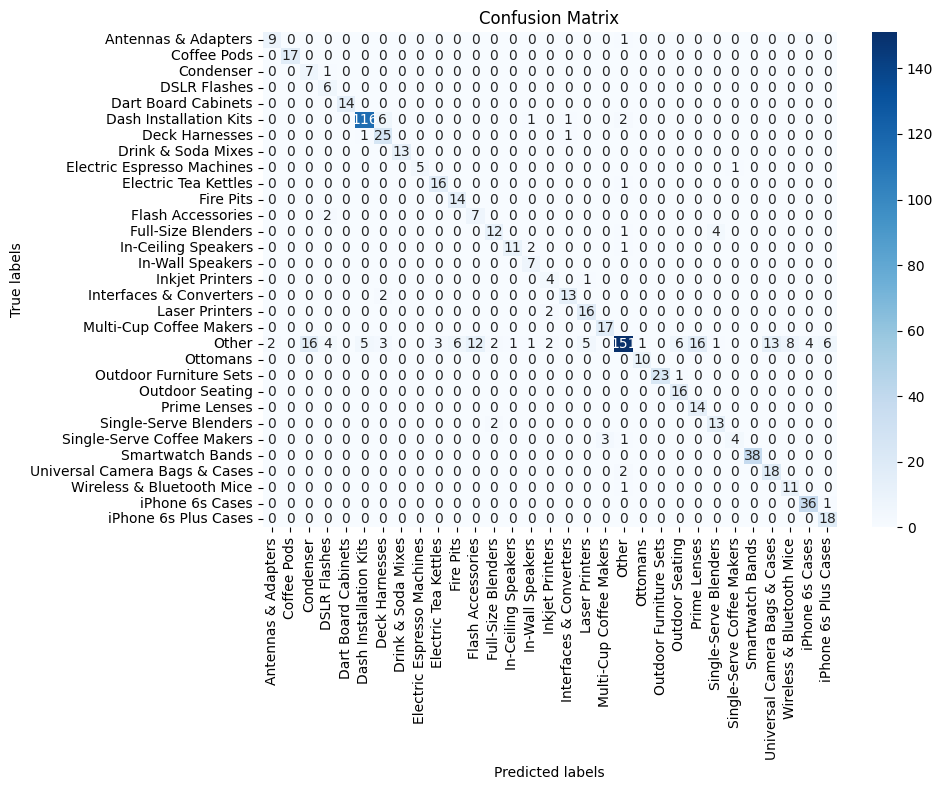

In [ ]:
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0001
EPOCH_TO_DECAY = 1960
DECAY = 0.9
THRESHOLD = 0.80
DENSE1 = 700
DENSE2 = 512
DENSE3 = 64
DENSE4 = 0

mlflow.end_run()
with open('/content/drive/MyDrive/models_compartida/my_runs.db'):
  print(f'{best_f1_so_far=}')

  clear_enviroment()
  model = give_me_my_model(LEARNING_RATE, EPOCH_TO_DECAY, DECAY, NUMBER_OUT, DENSE1, DENSE2, DENSE3, DENSE4)
  run = mlflow.start_run(run_name=f'{MLFLOW_EXPERIMENT_NAME}_N_{EXPERIMENT_NUMBER}')

  history = model.fit(dataset_train, epochs=  NUM_EPOCHS, validation_data=dataset_test, class_weight=COMPUTE_CLASS, callbacks=[call_early, CustomCallback()])

  ## log params
  mlflow.log_param('NUM_EPOCHS', NUM_EPOCHS)
  mlflow.log_param('LEARNING_RATE', LEARNING_RATE)
  mlflow.log_param('STEPS_TO_DECAY', EPOCH_TO_DECAY)
  mlflow.log_param('DECAY', DECAY)
  mlflow.log_param('N_LEVEL', LEVEL)
  mlflow.log_param('THRESHOLD', THRESHOLD)
  mlflow.log_param('EXPERIMENT_NUMBER', EXPERIMENT_NUMBER)
  mlflow.log_param('COMPUTE_CLASS', COMPUTE_CLASS)
  mlflow.log_param('MONITOR EARLY STOPPING', 'val_accuracy')
  mlflow.log_param('PATENCE EARLY STOPPING', 9)
  mlflow.log_param('SEED', SEED)

  if 'last_dense' in dir():
    print(f'{last_dense}')

  if 'metrics.png' in os.listdir('/content'):
    os.rename('/content/metrics.png', '/content/old_metrics.png')
    print('this is the old metric')
    fig = plt.figure(figsize=(10, 10))
    old_img = tf.keras.preprocessing.image.load_img('/content/old_metrics.png')
    plt.imshow(old_img)
  print(f'{best_f1_so_far=}')

  ## Save plots
  get_model_plot(model, )
  plots_gra(history, True)
  #test
  get_consufion_matrix(test_data_join, test_label_le, 'test')
  #val
  get_consufion_matrix(val_data_join, val_label_le, 'val')

  mlflow.log_artifact('/content/plot_model.png')
  mlflow.log_artifact('/content/con_matrix_val.png')
  mlflow.log_artifact('/content/con_matrix_test.png')
  mlflow.log_artifact('/content/metrics.png')


  ## evaluate the model
  predict_test = model.predict(test_data_join)
  predict_test = np.argmax(predict_test, axis=1)
  f1_test = f1_score(test_label_le, predict_test, average='weighted')
  print(f'{f1_test=}')
  mlflow.log_metric('final f1 test', f1_test)

  predict_val = model.predict(val_data_join)
  predict_val = np.argmax(predict_val, axis=1)
  f1_val = f1_score(val_label_le, predict_val, average='weighted')
  print(f'val = {f1_val=}')

  mlflow.log_metric('final f1 val', f1_val)

  if f1_val > best_f1_so_far['val'] and f1_test > best_f1_so_far['test']:
    print('best_f1_so_far has been update' )
    best_f1_so_far = {'val':f1_val, 'test':f1_test}
    best_lear = LEARNING_RATE
    epochs_to = EPOCH_TO_DECAY
    decay = DECAY
    for n in range(1,10):
      if f'DENSE{n}' in dir():
        best_dense[f'BEST_DENSE{n}'] = globals()[f'DENSE{n}']
      else:
        break
    mlflow.log_param('best dense', str(best_dense))

  if 'best_lear' in dir():
    print(f'The best hyperparam so far as lr {best_lear}, epochs_to  {epochs_to}, decay {decay}')

  if 'best_dense' in dir():
    print(f'{best_dense}')

  mlflow.log_metric('best f1 so far_val', best_f1_so_far['val'])
  mlflow.log_metric('best f1 so far_test', best_f1_so_far['test'])

  if f1_val >= THRESHOLD and f1_test >= THRESHOLD :
    print('the threshold has been overcome')
    config = model.get_config()
    weights = model.get_weights()
    model.save('/content/model.keras')
    model.save_weights('model_weights.h5')
    model_config = model.to_json()
    with open('model_config.json', 'w') as json_file:
      json_file.write(model_config)

    mlflow.log_artifact('model_weights.h5',)
    mlflow.log_artifact('model_config.json',)
    mlflow.log_artifact('model.keras')

  for n in range(1,10):
    if f'DENSE{n}' in dir():
      last_dense.append(globals()[f'DENSE{n}'])

    else:
      print(f'{last_dense}')
      break

  mlflow.end_run()

## add 1 to experiment
EXPERIMENT_NUMBER += 1